## Translate Wikidata ferry objects and upload with QuickStatements

* https://github.com/salgo60/Stockholm_Archipelago_Trail/issues/108
* Test all Wikidata ferry objects related to SAT wd:Q133724252
* Count number of SAT  objects has a label
  *  Bubble chart https://w.wiki/EjRK
  *  Table https://w.wiki/EjRP
* SPARQL find labels missing for a list of labels https://w.wiki/EjRR 

* Write code that generate the following languages en fr de nn nb it pl es pl pt ar ru zh fi da nl ja fa uk ku fit se sma smj sje sju rmy yi et lv lt cs hu el tr ko hi th vi he id ms is fo

In [10]:
import time
start_time = time.time()

In [11]:
from datetime import datetime
from SPARQLWrapper import SPARQLWrapper, JSON
import sys

def count_labels_by_language_SAT():
    """
    Counts the number of SAT trail objects that have labels, grouped by language.

    Parameters:

    Returns:
        List[Dict]: A list of dictionaries with keys 'lang' and 'count'
    """
    print (f"count_labels_by_language - SAT")
    endpoint_url = "https://query.wikidata.org/sparql"

    query = f"""
    SELECT ?lang (COUNT(?item) AS ?count) WHERE {{
      ?item wdt:P6104 wd:Q134294510 .
      ?item wdt:P31 wd:Q133867301 .
      minus {{?item wdt:P2789 ?xxx}}

      ?item rdfs:label ?label .
      BIND(LANG(?label) AS ?lang)
    }}
    GROUP BY ?lang
    ORDER BY DESC(?count)
    """

    user_agent = f"SAT-LabelCounter-Python/{sys.version_info[0]}.{sys.version_info[1]}"
    sparql = SPARQLWrapper(endpoint_url, agent=user_agent)
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    results = sparql.query().convert()

    return [
        {"lang": result["lang"]["value"], "count": int(result["count"]["value"])}
        for result in results["results"]["bindings"]
    ]


In [27]:
data = count_labels_by_language_SAT()


count_labels_by_language - SAT


In [13]:
data


[{'lang': 'fi', 'count': 11},
 {'lang': 'da', 'count': 11},
 {'lang': 'de', 'count': 11},
 {'lang': 'fr', 'count': 11},
 {'lang': 'en', 'count': 11},
 {'lang': 'sv', 'count': 11},
 {'lang': 'yi', 'count': 11},
 {'lang': 'it', 'count': 11},
 {'lang': 'es', 'count': 11},
 {'lang': 'zh', 'count': 11},
 {'lang': 'ur', 'count': 11},
 {'lang': 'uk', 'count': 11},
 {'lang': 'ru', 'count': 11},
 {'lang': 'pl', 'count': 11},
 {'lang': 'ja', 'count': 11},
 {'lang': 'fa', 'count': 11},
 {'lang': 'ar', 'count': 11},
 {'lang': 'lv', 'count': 11},
 {'lang': 'lt', 'count': 11},
 {'lang': 'hu', 'count': 11},
 {'lang': 'el', 'count': 11},
 {'lang': 'cs', 'count': 11},
 {'lang': 'is', 'count': 11},
 {'lang': 'tr', 'count': 11},
 {'lang': 'smj', 'count': 1},
 {'lang': 'sma', 'count': 1},
 {'lang': 'sju', 'count': 1},
 {'lang': 'sje', 'count': 1},
 {'lang': 'se', 'count': 1},
 {'lang': 'rmy', 'count': 1},
 {'lang': 'pt', 'count': 1},
 {'lang': 'nn', 'count': 1},
 {'lang': 'nl', 'count': 1},
 {'lang': 'nb'

In [24]:
import matplotlib.pyplot as plt
from datetime import datetime

def plot_language_distribution(data):
    """
    Plots a pie and bar chart of language distribution side by side.

    Parameters:
    - data: List[Dict[str, Any]] — a list of dictionaries with keys 'lang' and 'count'.
    """
    # Prepare data for plotting
    labels = [entry["lang"] for entry in data]
    sizes = [entry["count"] for entry in data]

    # Current timestamp
    today_str = datetime.now().strftime("%Y-%m-%d %H:%M")
    title = f"SAT — {today_str}"

    # Create side-by-side plots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

    # Pie chart
    ax1.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
    ax1.axis('equal')  # Equal aspect ratio ensures pie is drawn as a circle
    ax1.set_title(f'Language Distribution (Pie)\n{title}')

    # Bar chart
    ax2.bar(labels, sizes)
    ax2.set_xticks(range(len(labels)))
    ax2.set_xticklabels(labels, rotation=90)
    ax2.set_ylabel('Count')
    ax2.set_title(f'Language Count (Bar)\n{title}')

    plt.tight_layout()
    plt.show()


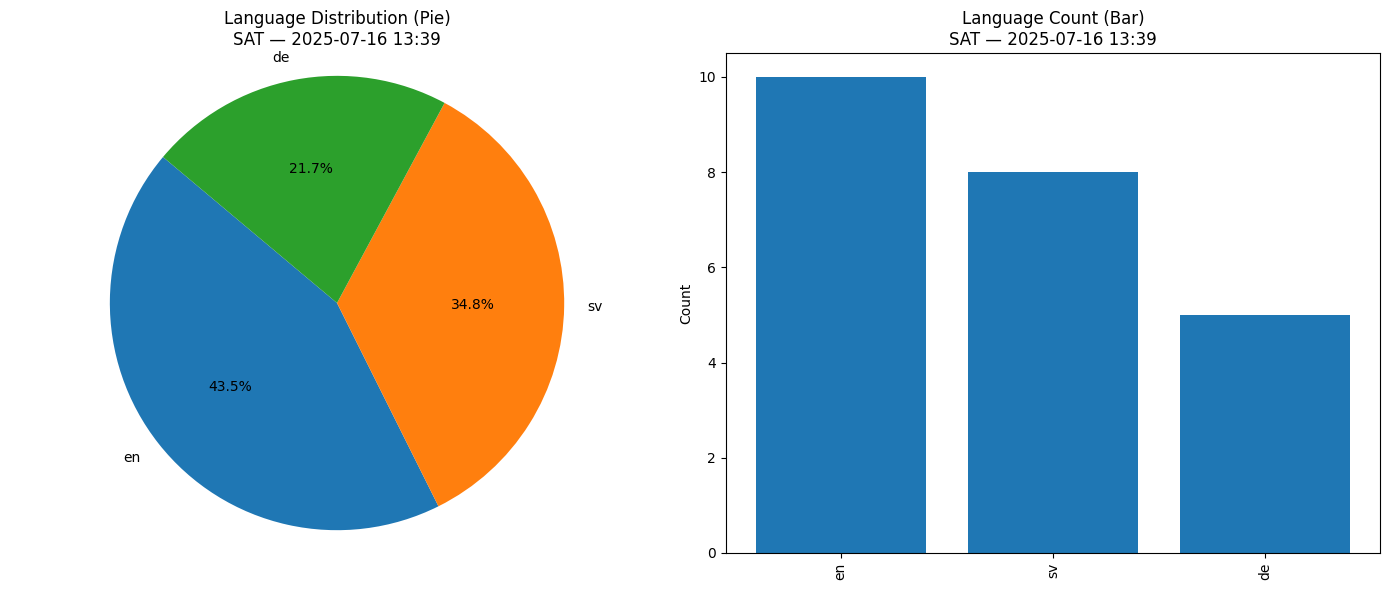

In [26]:

plot_language_distribution(data)


In [15]:
import pandas as pd
from deep_translator import GoogleTranslator

## get supported languages  
langs_list = GoogleTranslator().get_supported_languages()  # output: [arabic, french, english etc...]
#langs_list

In [16]:
langs_dict = GoogleTranslator().get_supported_languages(as_dict=True)  # output: {arabic: ar, french: fr, english:en etc...}
#langs_dict

In [17]:
# see https://github.com/salgo60/Stockholm_Archipelago_Trail/issues/104#issuecomment-3070692372
def get_lang_code(GoogleLangCode):
    if GoogleLangCode == "zh":
        return "zh-CN"
    return GoogleLangCode


In [20]:

from deep_translator import GoogleTranslator

# Build language support set from name → code mapping
lang_name_to_code = GoogleTranslator().get_supported_languages(as_dict=True)
supported_lang_codes = set(lang_name_to_code.values())

# Track which languages we've already logged
unsupported_warned = set()
supported_logged = set()

def translate_label(label_sv, target_lang):
    """
    Translate a label from Swedish to the target language if supported by Google Translate.
    Logs support status the first time each language is encountered.

    Returns:
        str or None: The translated label, or None if unsupported or failed.
    """
    if target_lang not in supported_lang_codes:
        if target_lang not in unsupported_warned:
            print(f"❌ Google Translate does NOT support: '{target_lang}' — skipping")
            unsupported_warned.add(target_lang)
        return None
    else:
        if target_lang not in supported_logged:
            print(f"✅ Google Translate supports: '{target_lang}'")
            supported_logged.add(target_lang)

    try:
        return GoogleTranslator(source='sv', target=target_lang).translate(label_sv)
    except Exception as e:
        print(f"⚠️ Translation error for '{target_lang}': {e}")
        return None


In [34]:
# https://github.com/salgo60/Stockholm_Archipelago_Trail/issues/104 
# "Test translate with use python deep_translator and create a QuickView file "
# 
# pip install sparqlwrapper
# https://rdflib.github.io/sparqlwrapper/

import sys
from SPARQLWrapper import SPARQLWrapper, JSON

today_str_filename = datetime.now().strftime("%Y-%m-%d_%H-%M")


endpoint_url = "https://query.wikidata.org/sparql"
# "el" "cs" "lv" "hu" "lt" "tr"
# "ja" "ar" "ur" "uk" "pl" "fa" "zh" "ru"
# "fi" "ru" "pl" "ar" "uk" "es" "ja" "tr" "zh" "it"
# "se"
queryFerryStop = f"""
SELECT ?langValue ?item ?Lsv ?Dsv WHERE {{
  VALUES ?langValue {{
    "fi" "ru" "pl" "ar" "uk" "es" "ja" "tr" "zh" "it" "ur" "fa" 
    "da" "de" "fr" "nl" "se"
  }}

  ?item wdt:P6104 wd:Q134294510 ;        
        rdfs:label ?Lsv ;
        schema:description ?Dsv .
   ?item wdt:P31 wd:Q133867301 .
   minus {{?item wdt:P2789 ?xxx}}

  FILTER(LANG(?Lsv) = "sv")
  FILTER(LANG(?Dsv) = "sv")

  FILTER NOT EXISTS {{
    ?item rdfs:label ?missingLabel .
    FILTER(LANG(?missingLabel) = ?langValue)
  }}

  SERVICE wikibase:label {{ bd:serviceParam wikibase:language "sv,mul,en,de". }}
}}
ORDER BY ?item ?langValue
"""

def get_results(endpoint_url, query):
    user_agent = "WDQS-example Python/%s.%s" % (sys.version_info[0], sys.version_info[1])
    # TODO adjust user agent; see https://w.wiki/CX6
    sparql = SPARQLWrapper(endpoint_url, agent=user_agent)
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    return sparql.query().convert()

results = get_results(endpoint_url, queryFerryStop)
# Samla resultat
output_lines = []

from tqdm.notebook import tqdm
from deep_translator import GoogleTranslator

# Example variables (adjust as needed)
today_str_filename = datetime.now().strftime("%Y-%m-%d_%H%M")
output_lines = []

# Loop with progress bar 
for result in tqdm(results["results"]["bindings"], desc="Translating", unit="item"):
    langValue = result["langValue"]["value"]
    wd = result["item"]["value"].replace("http://www.wikidata.org/entity/", "")
    Lsv = result["Lsv"]["value"]
    Dsv = result["Dsv"]["value"]

    label_trans = translate_label(Lsv, langValue)
    desc_trans = translate_label(Dsv, langValue)

    # Only write lines if BOTH translations succeeded
    if label_trans and desc_trans:
        output_lines.append(f'{wd}|L{langValue}|"{label_trans}"')
        output_lines.append(f'{wd}|D{langValue}|"{desc_trans}"')


# Save to file if 
output_filename = f"translated_labels_descriptions_ferry_stops_{today_str_filename}.txt"
with open(output_filename, "w", encoding="utf-8") as f:
    f.write("\n".join(output_lines))

print(f"✅ Klar! Resultatet är sparat i '{output_filename}'.")


Translating:   0%|          | 0/20 [00:00<?, ?item/s]

✅ Google Translate supports: 'nl'
✅ Klar! Resultatet är sparat i 'translated_labels_descriptions_ferry_stops_2025-07-16_1345.txt'.


### Next step run Quickstatement 
* https://qs-dev.toolforge.org/
* rerun stats



count_labels_by_language - SAT


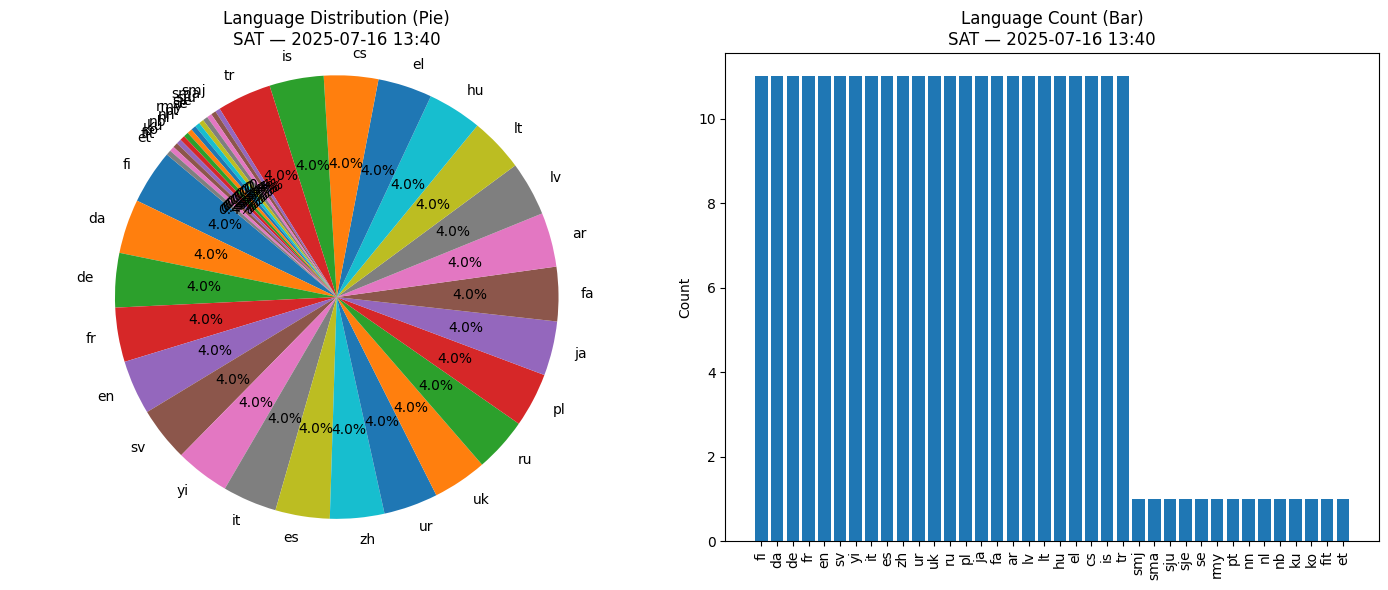

In [28]:
data = count_labels_by_language_SAT()
plot_language_distribution(data)


In [30]:
end_time = time.time() 

print(f"[{datetime.now().strftime('%Y-%m-%d %H:%M')}] Script run time: {end_time - start_time:.2f} seconds")

[2025-07-16 13:40] Script run time: 241.37 seconds
